# Project 2: Bipartite Network Analysis

## Data 620 Web Analytics

### Kyle Gilde

### 10/13/18

#### Instructions

1. Identify a large 2-mode network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?




In [255]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite as bp
from copy import deepcopy

## Presentation

[YouTube link](https://www.youtube.com/watch?v=wEbQ3wvqwlQ)

## About the Data

From the [Konect site](http://konect.uni-koblenz.de/), I chose a membership network of Github users & projects. The data set was collected during a [2009 Github contest](https://github.com/blog/466-the-2009-github-contest), and it contains the names of the users & projects. Each edge indicates that the user is a member of the Github project. We will project the adjacency matrix into both user and project networks and examine their characteristics.


First, let's parse a bipartite graph from the edgelist and add the node names as attributes.

In [26]:
# create graph
G_txt = open('Data/out.github', 'r')
G = bp.parse_edgelist(G_txt, nodetype=int, comments='%', delimiter=' ')

## Examine, Resize & Project the Bipartite Graph

The 2-mode graph contains over 120K nodes, nearly 440K edges & 3 component subgraphs.

In [4]:
def print_graph_stats(G):
    print("nodes", "edges", "component subgraphs")
    print(G.number_of_nodes(), G.number_of_edges(), nx.number_connected_components(G))

print_graph_stats(G)

nodes edges component subgraphs
120867 439930 3


The network has nearly 41K user nodes and nearly 80K project nodes.

In [5]:
G_user_nodes = [x for x, y in G.nodes(data=True) if y['bipartite'] == 0] # https://stackoverflow.com/questions/31922917/select-network-nodes-with-a-given-attribute-value
G_project_nodes = [x for x, y in G.nodes(data=True) if y['bipartite'] == 1]
print(len(G_user_nodes), len(G_project_nodes))

40968 79899


When we examine the subgraphs, we see that all except 2 nodes are in one subgraph. We will drop these 2 nodes.

In [6]:
subs = list(nx.connected_component_subgraphs(G))
print([sub.number_of_nodes() for sub in subs])
disconnected_nodes = list(subs[1].nodes) + list(subs[2].nodes)

G2 = deepcopy(G) 
G2.remove_nodes_from(disconnected_nodes)

[120865, 1, 1]


Because the graph is not weighted, we cannot easily apply the island method demonstrated in the book. Instead, let's use the example from chapter 3 and trim some of the nodes based upon the number of degrees. Let's take a look at the distribution of degrees among the user & project nodes.

In [9]:
G2_user_nodes = [x for x, y in G2.nodes(data=True) if y['bipartite'] == 0] # use to filter
G2_project_nodes = [x for x, y in G2.nodes(data=True) if y['bipartite'] == 1] # use to filter

node_dict = dict(nx.degree(G2)) # node degress
node_df = pd.DataFrame(list(node_dict.items()), columns=['node', 'measure']) # https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
user_node_df, project_node_df = node_df[node_df.node.isin(G2_user_nodes)], node_df[node_df.node.isin(G2_project_nodes)]
project_node_df.measure.value_counts()[:55]

1     54365
2      7107
3      4195
4      2827
5      1969
6      1319
7       990
8       798
9       598
10      521
11      398
12      342
13      326
14      276
15      243
16      191
18      177
17      162
20      152
19      150
21      119
22      108
23       96
24       94
26       88
25       86
28       75
30       73
27       67
31       66
29       63
32       56
34       55
35       48
42       45
38       44
46       42
33       42
40       39
41       38
37       36
50       32
36       30
44       28
47       27
39       27
43       25
48       25
54       24
52       23
61       23
55       21
51       21
49       20
57       20
Name: measure, dtype: int64

In [161]:
user_node_df.measure.value_counts()[:20]

2     13441
3      7087
4      3533
5      2334
6      1690
7      1357
8       999
9       891
10      738
11      599
12      530
13      482
14      459
15      400
16      370
17      325
18      286
19      254
21      253
20      245
Name: measure, dtype: int64

In order to trim the graph down to a reasonable size for this analysis, let's only select the user nodes having between 3 and 20 degrees & the project nodes that have exactly 49 collaborators.

In [16]:
user_nodes_to_remove = user_node_df[~((user_node_df.measure >= 3) & (user_node_df.measure <= 20))].node
project_nodes_to_remove = project_node_df[(project_node_df.measure != 49)].node

nodes_to_remove = project_nodes_to_remove.append(user_nodes_to_remove)
G3 = deepcopy(G2)
G3.remove_nodes_from(nodes_to_remove)

We have now significantly reduced the nodes and edges, but we now have nearly 11K component subgraphs. All of the subgraphs except one have only a handful of nodes. Let's use the largest subgraph for this analysis. This graph has about 5K nodes & edges.

In [17]:
print_graph_stats(G3)
# subgraphs
G3_subs = list(nx.connected_component_subgraphs(G3))
G3_sub_degrees = pd.Series([sub.number_of_nodes() for sub in G3_subs]).sort_values(ascending=False)
max_G3_sub = max(G3_sub_degrees)
# remove single nodes
single_nodes = []
for G3_sub in G3_subs:
    if G3_sub.number_of_nodes() != max_G3_sub:
        single_nodes += list(G3_sub.nodes)

G4 = deepcopy(G3)
G4.remove_nodes_from(single_nodes)

print_graph_stats(G4)

nodes edges component subgraphs
22599 12067 10825
nodes edges component subgraphs
5018 5221 1


Let's create unipartite projections from the barpartite graph. This is done by multiplying the bimodal adjacency matrix by its transpositions.

In [24]:
user_nodes = [x for x, y in G4.nodes(data=True) if y['bipartite'] == 0] # https://stackoverflow.com/questions/31922917/select-network-nodes-with-a-given-attribute-value
project_nodes = [x for x, y in G4.nodes(data=True) if y['bipartite'] == 1]
users, projects = bp.projected_graph(G4, user_nodes), bp.projected_graph(G4, project_nodes)

Let's create the user and project names and then add them as attributes to each graph.

In [243]:
# parse user and project names
node_names = pd.read_csv('Data/ent.github.repository.name', header=None, names=['name'])
node_names[['user_name', 'project_name']] = node_names.name.str.split('/', 1, expand=True) # https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns
node_names['node'] = node_names.index + 1

# add name attribute
user_name_dict = dict(zip(node_names.node, node_names.user_name)) # https://stackoverflow.com/questions/18012505/python-pandas-dataframe-columns-convert-to-dict-key-and-value/18013682
nx.set_node_attributes(users, user_name_dict, 'name')
project_name_dict = dict(zip(node_names.node, node_names.project_name)) 
nx.set_node_attributes(projects, project_name_dict, 'name')

## Unipartite Users Graph

The users graph contains over 5K nodes, over 9K edges & no component subgraphs.

In [39]:
print_graph_stats(users)

nodes edges component subgraphs
5018 9533 1


The plot shows a network that has a moderately dense core with some peripheral nodes.

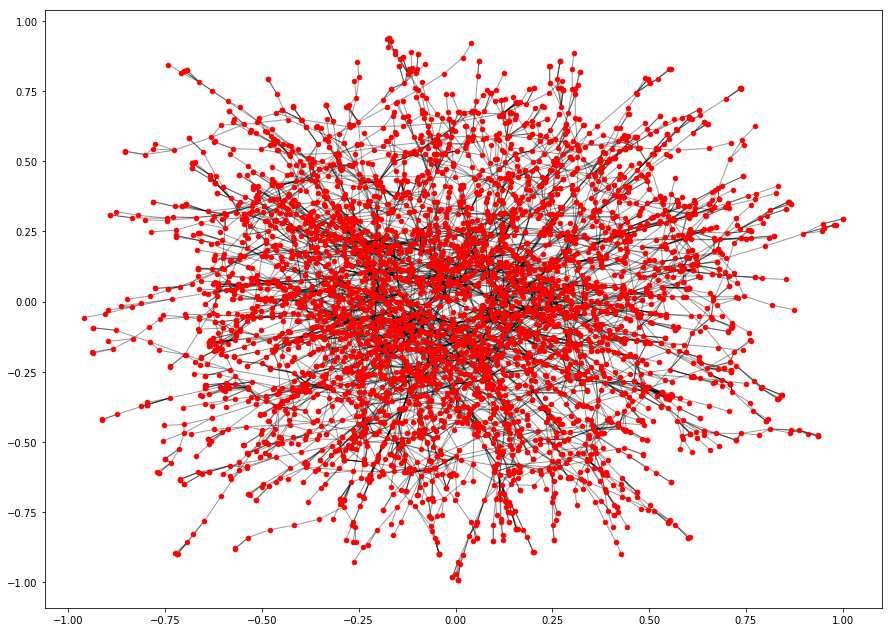

In [226]:
plt.figure(figsize=(15, 11))
pos = nx.spring_layout(users)
nx.draw_networkx_nodes(users, pos, node_size=20)
nx.draw_networkx_edges(users, pos, alpha=0.4)

### User Centrality

We will use the following function to examine the centralities for this graph. 

In [212]:
def centrality_df(g, function):
    if function in ['degree', 'eigenvector', 'betweenness', 'closeness']:
        if function == 'degree':
            node_measure_dict = dict(nx.degree_centrality(users)) 
        elif function == 'eigenvector':    
            node_measure_dict = dict(nx.eigenvector_centrality(users)) 
        elif function == 'betweenness':    
            node_measure_dict = dict(nx.betweenness_centrality(users)) 
        else:        
            node_measure_dict = dict(nx.closeness_centrality(users)) 
    
        node_measure_df = pd.DataFrame(list(node_measure_dict.items()), columns=['node', 'measure']) # https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
        node_name_dict = dict(nx.get_node_attributes(users, 'name'))
        node_name_df = pd.DataFrame(list(node_name_dict.items()), columns=['node', 'name'])
        node_df = pd.merge(node_measure_df, node_name_df, how='left', on='node').set_index('name').drop('node', axis=1)
        return node_df.sort_values('measure', ascending=False)
    else: 
        print('Error: please select one of the following functions: degree, eigenvector, betweenness, closeness')

#### Degree Centrality

Degree centrality is calculated by counting the number of edges for each node and dividing by one less than the number of nodes. 

Looking at the degree centrality, we see that the mean is small, and the range is rather narrow.

count    5018.000000
mean        0.000757
std         0.000548
min         0.000199
25%         0.000399
50%         0.000598
75%         0.000997
max         0.005581
Name: measure, dtype: float64


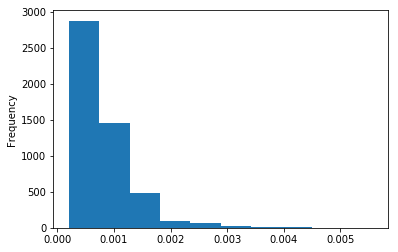

In [69]:
user_degree_measures = centrality_df(users, 'degree')
print(user_degree_measures.measure.describe())
user_degree_measures.measure.plot.hist()

Here are the top Github users by degree centrality.

In [67]:
degree_measures[:10]

,measure
name,
phishy,0.005581
sethtrain,0.005382
jesper,0.004983
Manfred,0.004385
malife,0.004186
dustin,0.004186
drforr,0.004186
drnic,0.003986
chorny,0.003986


#### Eigenvector Centrality

Eigenvector centrality is like a weighted version of degree centrality, where the centrality metric for a node is the sum of all of the degrees possessed by the neighbors normalized by the largest value. This process is repeated until the largest value stops changing.

The distribution of these values is bifurcated. Nearly all of the values are close to zero except for a clump of values greater than .2.

count    5018.000000
mean        0.000942
std         0.014087
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.246625
Name: measure, dtype: float64


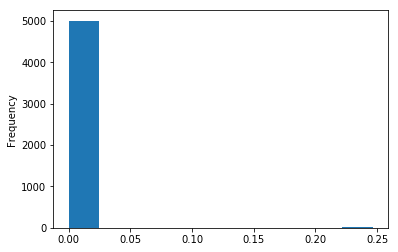

In [88]:
user_eigenvector_measures = centrality_df(users, 'eigenvector')
print(round(user_eigenvector_measures.measure.describe(), 6))
user_eigenvector_measures.measure.plot.hist()

Looking at the top values, we can see that the first 16 Github users compose the clump greater than .2.

In [79]:
user_eigenvector_measures[:20].reset_index()

,name,measure
0,Manfred,0.246625
1,malife,0.245417
2,drforr,0.245353
3,thisgeek,0.242131
4,pacocsfs,0.241920
5,diclophis,0.241920
6,texel,0.240933
7,zedalaye,0.240926
8,lindsayevans,0.240047
9,jburr,0.240047


Only 3 of the top 10 degree centrality nodes are also among the top 10 eigenvector centrality nodes. This reflects the weighted aspect of eigenvector centrality.

In [98]:
user_deg10 = user_degree_measures[:10].index
user_ev10 = user_eigenvector_measures[:10].index
set(user_ev10) & set(user_deg10)

{'Manfred', 'drforr', 'malife'}

#### Betweenness Centrality

Betweenness is a measure of the degree to which nodes serve as bridges or bottlenecks between parts of the network. Nodes with betweenness connect parts of a network that would not otherwise be connected.

The average betweenness value is small. We will want to see if this indicates a relatively high clustering coefficient.

In [111]:
user_betweenness_measures = centrality_df(users, 'betweenness')

In [114]:
user_betweenness_measures.measure.describe()

count    5018.000000
mean        0.002959
std         0.009321
min         0.000000
25%         0.000000
50%         0.000000
75%         0.001196
max         0.187114
Name: measure, dtype: float64

#### Closeness Centrality

Closeness centrality is each node's average shortest path to all other nodes scaled by the maximum distance.

Of all the centralities, at 0.06, the mean closeness centrality is the highest.

In [112]:
user_closeness_measures = centrality_df(users, 'closeness')

In [113]:
user_closeness_measures.measure.describe()

count    5018.000000
mean        0.065021
std         0.010879
min         0.034698
25%         0.057471
50%         0.064658
75%         0.072457
max         0.094359
Name: measure, dtype: float64

### Other Measures 

With a mean clustering coefficient at 0.57, there is a moderate degree of clustering in the network. The coefficient represents the proportion of "mutual friends" that are also connected. For the typical Github user in our projected network, more than half of their mutual friends are connected.

In [115]:
nx.average_clustering(users)

0.5668989661742232

A clique is a maximal complete subgraph, which means that every node is connected to every other node.

Among the Github users, there are 2829 cliques.

In [126]:
clique_list = list(nx.find_cliques(users))
len(clique_list)

2829

Nearly all of the clique sizes are in the single digits. The biggest one is 17 users.

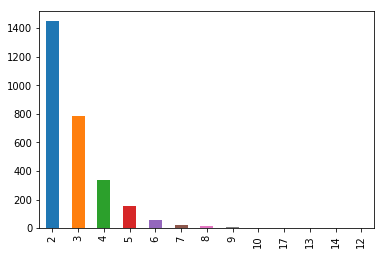

In [127]:
clique_len = pd.Series([len(clique) for clique in clique_list])
clique_len.value_counts().plot.bar()

## Unipartite Projects Graph

The projected Github projects network has more nodes than edges, meaning there are more projects than connections between projects. 

It contains 13 component subgraphs, which means that these 188 projects cannot be connected by their common users.

In [101]:
print_graph_stats(projects)

nodes edges component subgraphs
188 176 13


The plot below illustrates the 13 component subgraphs formed by the projects networks.

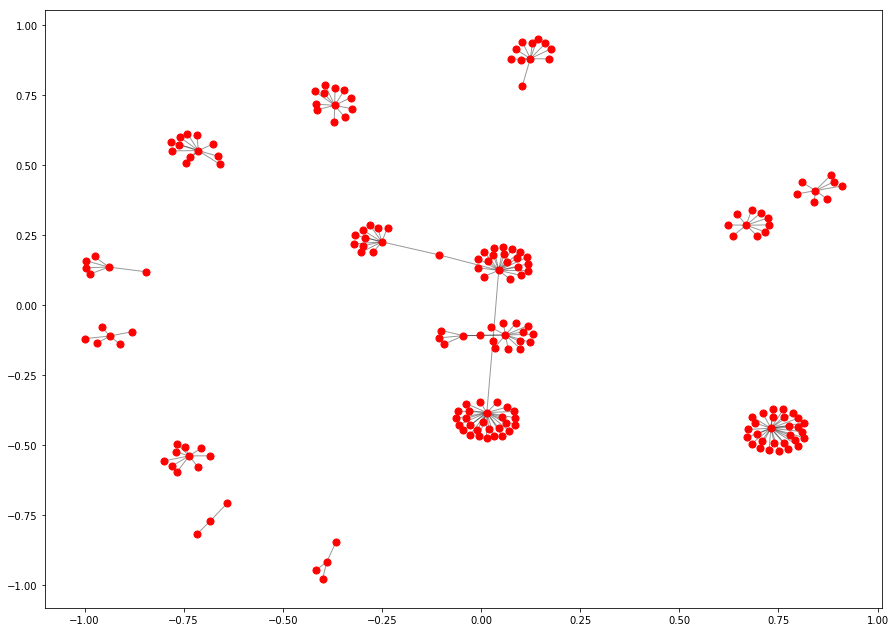

In [137]:
plt.figure(figsize=(15, 11))

pos = nx.spring_layout(projects)
node_labels = nx.get_node_attributes(projects, 'name')
nx.draw_networkx_nodes(projects, pos, node_size=50)
nx.draw_networkx_edges(projects, pos, alpha=0.4)
plt.show()

Let's take a closer look at the 2 largest subgraphs. We will call the largest one Graph A and the smaller one Graph B. 

In the plots below, we can see that these graphs look fundamentally different than the user graph. In the user graph, there were many mutual ties between nodes, but in the project graphs, we see that there are a handful of project nodes that connect other projects together.

Graph A has 60 nodes with some prominent bottlenecks and bridges, and Graph B has 29 nodes and looks a "broadcast" network with a single node connecting all the others. Let's see if our network metrics confirm what we see in these plots.

nodes edges component subgraphs
60 59 1
nodes edges component subgraphs
29 28 1


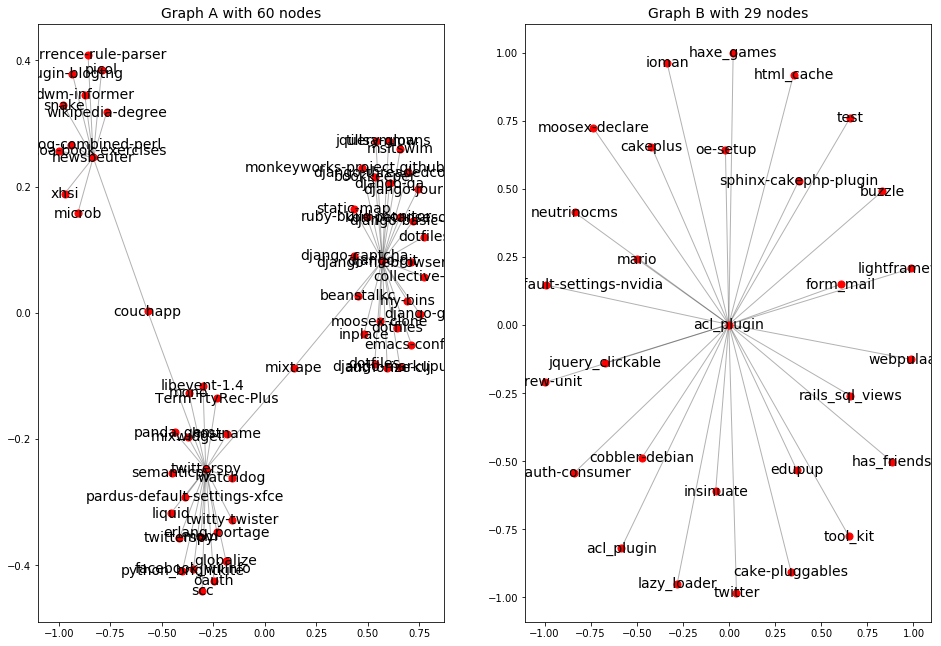

In [202]:
project_subs = list(nx.connected_component_subgraphs(projects))
project_subs_max_lens = sorted([len(sub) for sub in project_subs], reverse=True)[:2]
max_subs = [sub for sub in project_subs if len(sub) in project_subs_max_lens]
A, B = max_subs
max_sub_names = ['A', 'B']
print_graph_stats(A)
print_graph_stats(B)

plt.figure(figsize=(16, 11))
for i, max_sub in enumerate(max_subs):
    plt.subplot(1, 2, i + 1)
    labels = nx.get_node_attributes(max_sub, 'name')
    pos = nx.spring_layout(max_sub)
    nx.draw_networkx_edges(max_sub, pos, alpha=.3)
    nx.draw_networkx_nodes(max_sub, pos, node_size=50)      
    nx.draw_networkx_labels(max_sub, pos, labels, font_size=14)
    title = 'Graph ' + max_sub_names[i] + " with " + str(len(max_sub)) + ' nodes'
    plt.title(title, size=14)
plt.show()

From the plot of Graph A, we would expect a few of the nodes to have high betweenness centrality. In the table below, we see that there are only 5 projects with any betweenness at all.

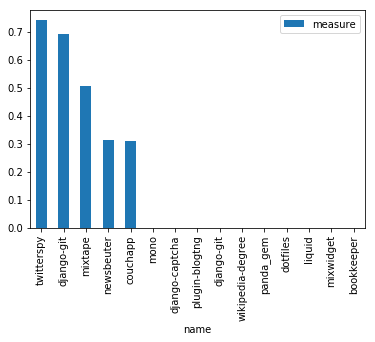

In [239]:
A_names = pd.DataFrame(list(dict(nx.get_node_attributes(A, 'name')).items()), columns=['node', 'name'])
A_betw = pd.DataFrame(list(dict(nx.betweenness_centrality(A)).items()), columns=['node', 'measure'])
A_betw = pd.merge(A_betw, A_names, on='node').sort_values('measure', ascending=False).drop('node', axis=1).set_index('name')
A_betw[:15].plot.bar()

From the plot of Graph B, we would expect only 1 node to have any betweenness. The project `acl_plugin` actually has a perfect betweenness score of 1.

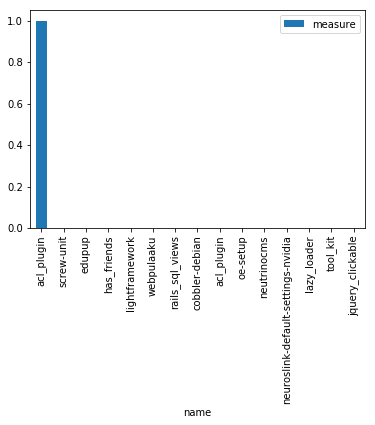

In [240]:
B_names = pd.DataFrame(list(dict(nx.get_node_attributes(B, 'name')).items()), columns=['node', 'name'])
B_betw = pd.DataFrame(list(dict(nx.betweenness_centrality(B)).items()), columns=['node', 'measure'])
B_betw = pd.merge(B_betw, B_names, on='node').sort_values('measure', ascending=False).drop('node', axis=1).set_index('name')
B_betw[:15].plot.bar()

`acl_plugin` is also the only project to have one than one degree. Its degree centrality score is 1.

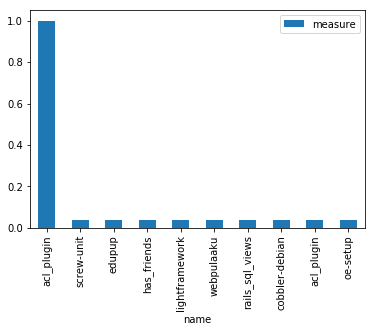

In [245]:
B_names = pd.DataFrame(list(dict(nx.get_node_attributes(B, 'name')).items()), columns=['node', 'name'])
B_degree = pd.DataFrame(list(dict(nx.degree_centrality(B)).items()), columns=['node', 'measure'])
B_degree = pd.merge(B_degree, B_names, on='node').sort_values('measure', ascending=False).drop('node', axis=1).set_index('name')
B_degree[:10].plot.bar()

As we suspected, unlike the user graph, neither of these project graphs have any clustering. None of the mutual friends are connected.

In [247]:
print(nx.average_clustering(A), nx.average_clustering(B))

0.0 0.0


Since we did not have a mutual friend ties, the largest clique in these graphs is only 2.

In [254]:
A_clique_list, B_clique_list = list(nx.find_cliques(A)), list(nx.find_cliques(B))
print(len(A_clique_list), len(B_clique_list))

A_clique_len = pd.Series([len(clique) for clique in A_clique_list])
B_clique_len = pd.Series([len(clique) for clique in B_clique_list])
print(max(A_clique_len), max(B_clique_len))

59 28
2 2
